In [1]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install dowhy
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


<ipython-input-2-455c92e3406f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['CIE'] = df1['kilotons_of_co2'] * 1e3 / df1['primary_energy_consumption']  # kg CO2/MWh
<ipython-input-2-455c92e3406f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['EAI'] = df1['energy_cons_change_pct']  # proxy for energy affordability
<ipython-input-2-455c92e3406f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

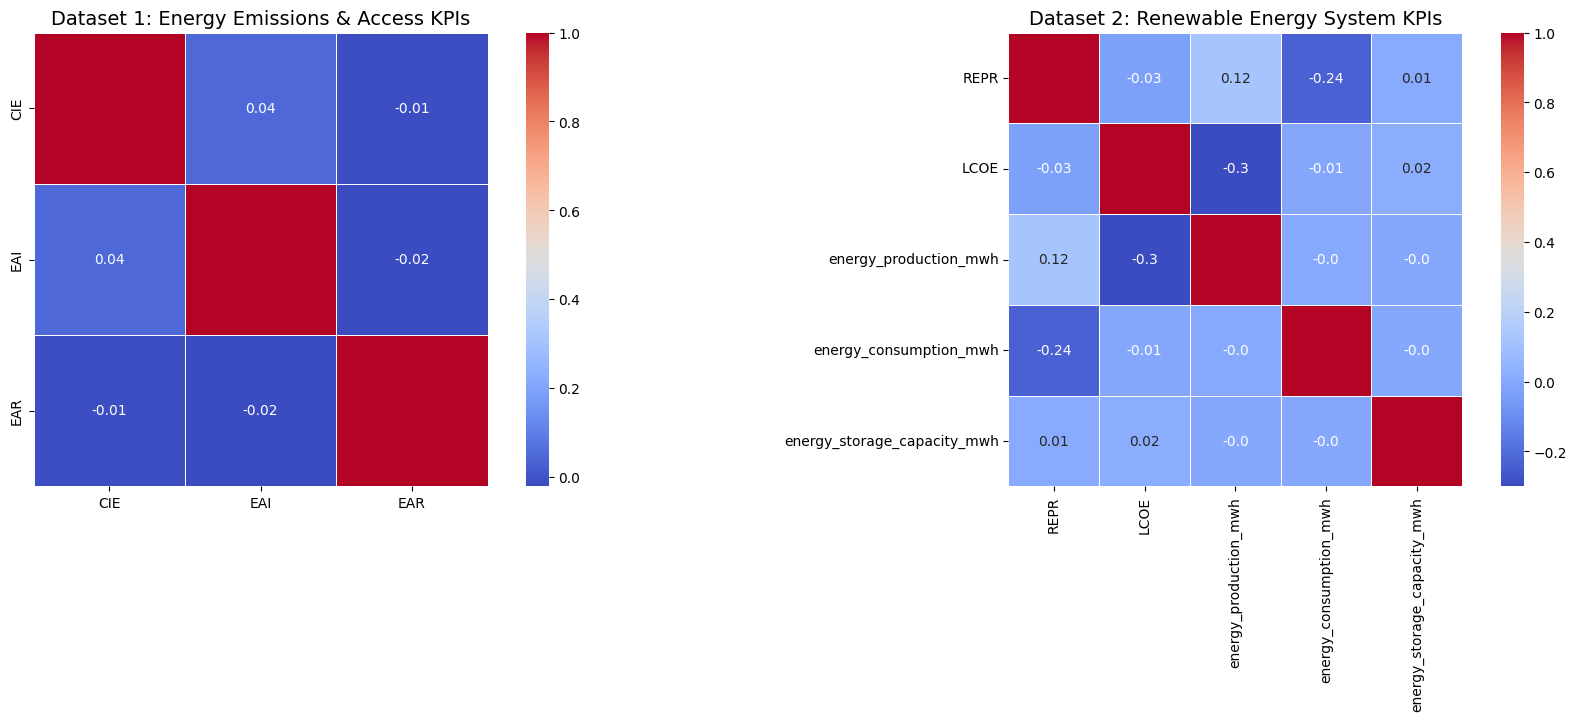

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your datasets
df1 = pd.read_csv("World Energy Consumption and CO2 Emissions Datatset.csv")
df2 = pd.read_csv("Fully_Mapped_Energy_Dataset.csv")

# =========================
# Preprocess Dataset 1
# =========================
df1['kilotons_of_co2'] = pd.to_numeric(df1['kilotons_of_co2'], errors='coerce')
df1['primary_energy_consumption'] = pd.to_numeric(df1['primary_energy_consumption'], errors='coerce')
df1['energy_cons_change_pct'] = pd.to_numeric(df1['energy_cons_change_pct'], errors='coerce')
df1['gas_production'] = pd.to_numeric(df1['gas_production'], errors='coerce')

df1 = df1.dropna(subset=['kilotons_of_co2', 'primary_energy_consumption', 'gas_production'])

# Calculate KPIs for Dataset 1
df1['CIE'] = df1['kilotons_of_co2'] * 1e3 / df1['primary_energy_consumption']  # kg CO2/MWh
df1['EAI'] = df1['energy_cons_change_pct']  # proxy for energy affordability
df1['EAR'] = df1['gas_production']  # proxy for energy access

dataset1_kpis = df1[['CIE', 'EAI', 'EAR']].dropna()

# =========================
# Preprocess Dataset 2
# =========================
df2['energy_production_mwh'] = pd.to_numeric(df2['energy_production_mwh'], errors='coerce')
df2['energy_consumption_mwh'] = pd.to_numeric(df2['energy_consumption_mwh'], errors='coerce')
df2['initial_investment_usd'] = pd.to_numeric(df2['initial_investment_usd'], errors='coerce')
df2['energy_storage_capacity_mwh'] = pd.to_numeric(df2['energy_storage_capacity_mwh'], errors='coerce')

# Calculate KPIs for Dataset 2
df2['REPR'] = df2['energy_production_mwh'] / df2['energy_consumption_mwh']
df2['LCOE'] = df2['initial_investment_usd'] / df2['energy_production_mwh']

dataset2_kpis = df2[['REPR', 'LCOE', 'energy_production_mwh', 'energy_consumption_mwh', 'energy_storage_capacity_mwh']].dropna()

# =========================
# Create Correlation Matrices
# =========================
corr_dataset1 = dataset1_kpis.corr()
corr_dataset2 = dataset2_kpis.corr()

# =========================
# Create Annotation DataFrames with Blank Diagonals
# =========================
def create_annot(corr_df):
    # Round the correlation values and convert to string
    annot = corr_df.round(2).astype(str)
    # Replace diagonal entries with empty strings
    for i in range(len(annot)):
        annot.iloc[i, i] = ""
    return annot

annot_dataset1 = create_annot(corr_dataset1)
annot_dataset2 = create_annot(corr_dataset2)

# =========================
# Plot Heatmaps Side-by-Side with "coolwarm" palette
# =========================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Dataset 1 Heatmap
sns.heatmap(
    corr_dataset1,
    annot=annot_dataset1,
    fmt="",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar=True,
    ax=axes[0]
)
axes[0].set_title('Dataset 1: Energy Emissions & Access KPIs', fontsize=14)

# Dataset 2 Heatmap
sns.heatmap(
    corr_dataset2,
    annot=annot_dataset2,
    fmt="",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar=True,
    ax=axes[1]
)
axes[1].set_title('Dataset 2: Renewable Energy System KPIs', fontsize=14)

plt.tight_layout()
plt.show()


In [15]:
df2['LCOE'] = df2['initial_investment_usd'] / df2['energy_production_mwh']

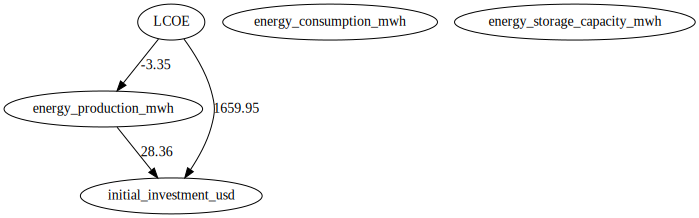

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygraphviz
from IPython.display import Image, display

from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased.lingam.utils import make_dot

# STEP 1: Rebuild dataset2_kpis with all required KPI columns
dataset2_kpis = df2[
    ['energy_production_mwh', 'LCOE', 'initial_investment_usd',
     'energy_consumption_mwh', 'energy_storage_capacity_mwh']
].dropna()

# STEP 2: Convert to NumPy format and define labels
df = dataset2_kpis.to_numpy()
labels = dataset2_kpis.columns.tolist()

# STEP 3: Fit ICALiNGAM model to discover causal structure
model = lingam.ICALiNGAM()
model.fit(df)

# STEP 4: Visualize the discovered causal graph
make_dot(model.adjacency_matrix_, labels=labels)


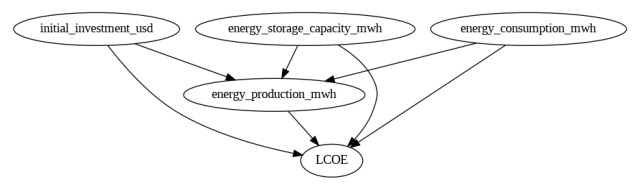

In [28]:
from dowhy import CausalModel

# Slightly simplified and fixed graph structure
graph = """digraph {
    initial_investment_usd -> energy_production_mwh;
    energy_storage_capacity_mwh -> energy_production_mwh;
    energy_consumption_mwh -> energy_production_mwh;

    initial_investment_usd -> LCOE;
    energy_storage_capacity_mwh -> LCOE;
    energy_consumption_mwh -> LCOE;

    energy_production_mwh -> LCOE;
}"""

model1 = CausalModel(
    data=dataset2_kpis,
    treatment="energy_production_mwh",
    outcome="LCOE",
    common_causes=[
        "initial_investment_usd",
        "energy_storage_capacity_mwh",
        "energy_consumption_mwh"
    ],
    graph=graph
)
# View graph
model1.view_model()

In [27]:
# Identify effect (warning is fine)
identified_estimand = model1.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                                       ↪
────────────────────────(E[LCOE|initial_investment_usd,energy_consumption_mwh,energy_storage_capac ↪
d[energy_production_mwh]                                                                           ↪

↪          
↪ ity_mwh])
↪          
Estimand assumption 1, Unconfoundedness: If U→{energy_production_mwh} and U→LCOE then P(LCOE|energy_production_mwh,initial_investment_usd,energy_consumption_mwh,energy_storage_capacity_mwh,U) = P(LCOE|energy_production_mwh,initial_investment_usd,energy_consumption_mwh,energy_storage_capacity_mwh)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [29]:
# Estimate causal effect anyway
causal_effect = model1.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print(f"Estimated Causal Effect of Energy Production on LCOE: {causal_effect}")


Estimated Causal Effect of Energy Production on LCOE: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                                       ↪
────────────────────────(E[LCOE|initial_investment_usd,energy_consumption_mwh,energy_storage_capac ↪
d[energy_production_mwh]                                                                           ↪

↪          
↪ ity_mwh])
↪          
Estimand assumption 1, Unconfoundedness: If U→{energy_production_mwh} and U→LCOE then P(LCOE|energy_production_mwh,initial_investment_usd,energy_consumption_mwh,energy_storage_capacity_mwh,U) = P(LCOE|energy_production_mwh,initial_investment_usd,energy_consumption_mwh,energy_storage_capacity_mwh)

## Realized estimand
b: LCOE~energy_production_mwh+initial_investment_usd+energy_consumption_mwh+energy_storage_capacity_mwh
Target units: ate

## Est

/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [31]:
refute1 = model1.refute_estimate(
    identified_estimand,
    causal_effect,
    method_name="random_common_cause"
)
print(refute1)




/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Refute: Add a random common cause
Estimated effect:-0.02684299482643837
New effect:-0.026842720930017095
p value:0.94



/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [32]:
refute2 = model1.refute_estimate(
    identified_estimand,
    causal_effect,
    method_name="data_subset_refuter"
)
print(refute2)

/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Refute: Use a subset of data
Estimated effect:-0.02684299482643837
New effect:-0.026916903901183106
p value:0.92



/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra